In [2]:
import numpy as np
from scipy.stats import unitary_group
from opt_einsum import contract

import tensorflow as tf
from src.QDDPM_tf import OneQubitDiffusionModel, QDDPM
from src.QDDPM_tf import naturalDistance, WassDistance

import time

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


# Generate diffusion data

In [3]:
def circleYGen(N_train, seed=None):
    '''
    generate random quantum states from RY(\phi)|0>
    assume uniform distribution
    '''
    np.random.seed(seed)
    phis = np.random.uniform(0, 2*np.pi, N_train)
    states = np.vstack((np.cos(phis), np.sin(phis))).T
    return states.astype(np.complex64)

distance measure behavior in the forward process

In [4]:
n = 1
T = 40
Ndata = 10
diff_hs = 1e-3*np.arange(1, T+1)**2

model_diff = OneQubitDiffusionModel(T, Ndata)
X = tf.convert_to_tensor(circleYGen(Ndata, seed=12))
Xout = np.zeros((T+1, Ndata, 2**n), dtype=np.complex64)
Xout[0] = X.numpy()

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed=t).numpy()
    print(t)
np.save('data/circle/circleYDiff_n1T%d_N%d.npy'%(T, Ndata), Xout)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Text(0.5, 0, '$t$')

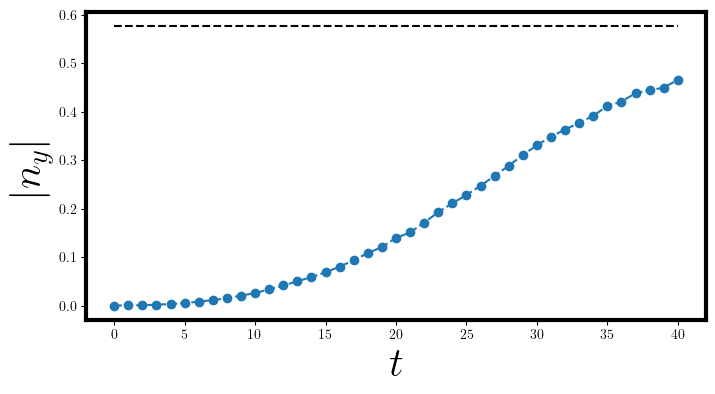

In [5]:
# plot the standard deviation of ny evolution
N = 5000
sy = np.array([[0,-1j],[1j,0]])
X = np.load('data/circle/circleYDiff_n1T40_N%d.npy'%N)
ys = contract('tmi, ij, tmj->tm', X.conj(), sy, X)

plt.figure(figsize=(8, 4))
plt.plot(range(41), np.mean(np.abs(ys), axis=1), 'o--')
plt.plot(range(41), 1/np.sqrt(3)*np.ones(41), '--', c='k')
plt.ylabel(r'$|n_y|$', fontsize=30)
plt.xlabel(r'$t$', fontsize=30)

# compare distance measures

In [6]:
N = 500
T = 40
X = tf.convert_to_tensor(np.load('data/circle/circleYDiff_n1T40_N5000.npy'))
X0 = tf.convert_to_tensor(circleYGen(N, seed=19))

mmd = np.zeros(T+1)
wass = np.zeros(T+1)
for t in range(T+1):
    np.random.seed()
    idx = np.random.choice(10*N, N, replace=False)
    mmd[t] = naturalDistance(X0, X[t, idx])
    wass[t] = WassDistance(X0, X[t, idx])

np.save('data/circle/circleYDiffdists_n1T40_N%d.npy'%N, np.vstack((mmd, wass)))

Cause: Unable to locate the source code of <function _gcd_import at 0x000001C02DC43D80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x000001C02DC43D80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function

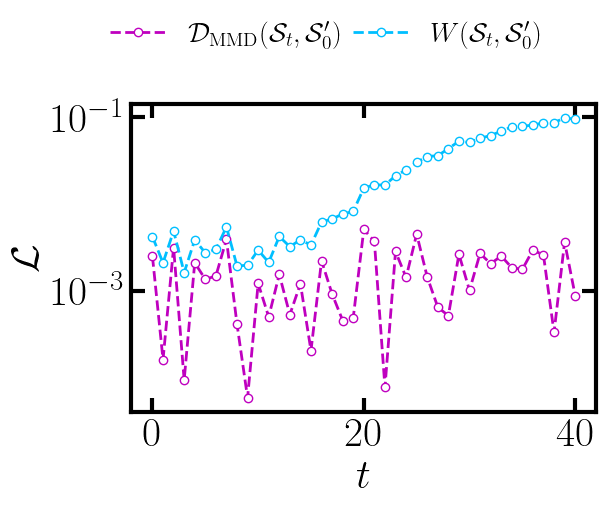

In [7]:
# plot different distance measures
N = 500
dists = np.load('data/circle/circleYDiffdists_n1T40_N%d.npy'%N)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(dists[0], 'o--', mfc='white', markersize=6, lw=2, c='m', 
        label=r'$\mathcal{D}_{\rm MMD}(\mathcal{S}_t,\mathcal{S}^\prime_0)$')
ax.plot(dists[1], 'o--', mfc='white', markersize=6, lw=2, c='deepskyblue', 
        label=r'$W(\mathcal{S}_t,\mathcal{S}^\prime_0)$')

ax.legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
ax.set_yscale('log')
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylabel(r'$\mathcal{L}$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)


# Training

In [8]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    Ndata: number of samples in training data set
    epochs: number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    tf.random.set_seed(None)
    params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
    # set optimizer and learning rate decay
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]
        with tf.GradientTape() as tape:
            output_t = model.backwardOutput_t(input_tplus1, params_t)
            loss = WassDistance(output_t, true_data)
        grads = tape.gradient(loss, [params_t])
        optimizer.apply_gradients(zip(grads, [params_t]))

        loss_hist.append(tf.stop_gradient(loss)) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))
        
    return tf.stop_gradient(params_t), tf.squeeze(tf.stack(loss_hist))

In [9]:
n, na = 1, 2
T = 40
L = 6
Ndata = 500
epochs = 5001

diffModel = OneQubitDiffusionModel(T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed=22)

states_diff = np.load('data/circle/circleYDiff_n1T40_N5000.npy')
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)



In [10]:
tf.random.set_seed(None)
params_t = tf.Variable(tf.random.normal([2 * model.n_tot * model.L]))
for t in range(T-1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, T):
        print("tt is %d"%tt)
        params_tot[tt] = np.load('data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%tt)
        
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
    np.save('data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%t, params.numpy())
    np.save('data/circle/QDDPMcircleYlosshist_n1na2T40L6_t%d_wd.npy'%t, loss_hist.numpy())

Step 0, loss: tf.Tensor(0.10231496, shape=(), dtype=float32), time elapsed: 16.317413091659546 seconds
Step 100, loss: tf.Tensor(0.071480215, shape=(), dtype=float32), time elapsed: 22.71290159225464 seconds
Step 200, loss: tf.Tensor(0.051922366, shape=(), dtype=float32), time elapsed: 29.218608140945435 seconds
Step 300, loss: tf.Tensor(0.022188079, shape=(), dtype=float32), time elapsed: 36.540051221847534 seconds
Step 400, loss: tf.Tensor(0.020630771, shape=(), dtype=float32), time elapsed: 43.628100872039795 seconds
Step 500, loss: tf.Tensor(0.014377788, shape=(), dtype=float32), time elapsed: 51.35284948348999 seconds
Step 600, loss: tf.Tensor(0.0076944954, shape=(), dtype=float32), time elapsed: 58.0192346572876 seconds
Step 700, loss: tf.Tensor(0.008275732, shape=(), dtype=float32), time elapsed: 64.48030996322632 seconds
Step 800, loss: tf.Tensor(0.007695937, shape=(), dtype=float32), time elapsed: 70.47921061515808 seconds
Step 900, loss: tf.Tensor(0.010021076, shape=(), dtype

# Performance

## generate training and testing data

In [11]:
# collect result
n, na = 1, 2
T = 40
L = 6
N_train = 5000

loss_tot = np.zeros((T, 5001))
params_tot = np.zeros((T, 2*(n+na)*L))
for t in range(T):
    loss_tot[t] = np.load('data/circle/QDDPMcircleYlosshist_n1na2T40L6_t%d_wd.npy'%t)
    params_tot[t] = np.load('data/circle/QDDPMcircleYparams_n1na2T40L6_t%d_wd.npy'%t)

np.save('data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy', loss_tot)
np.save('data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy', params_tot)

In [12]:
# generate data

n, na = 1, 2
T = 40
L = 6
Ndata = 500

diffModel = OneQubitDiffusionModel(T, Ndata)
inputs_T_tr = diffModel.HaarSampleGeneration(Ndata, seed=22)
inputs_T_te = diffModel.HaarSampleGeneration(Ndata, seed=23)

params_tot = np.load('data/circle/QDDPMcircleYparams_n1na2T40L6_wd.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_tr = model.backDataGeneration(inputs_T_tr, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(inputs_T_te, params_tot, Ndata)[:, :, :2**n].numpy()

np.save('data/circle/QDDPMcircleYtrainGen_n1na2T40L6_wd.npy', data_tr)
np.save('data/circle/QDDPMcircleYtestGen_n1na2T40L6_wd.npy', data_te)

## visualize in $\langle Y\rangle^2$

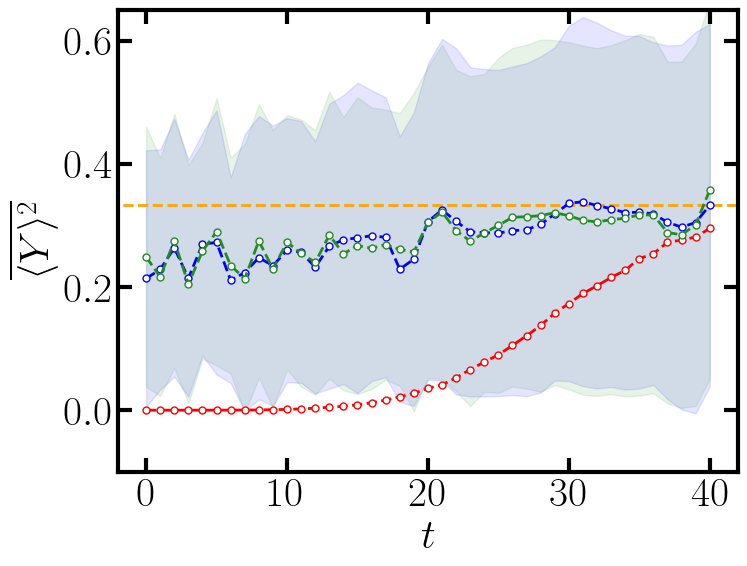

In [13]:
# plot training and test result (in vertical representation)
n, na = 1, 2
T = 40
L = 6
Ndata = 500

states_diff = np.load('data/circle/circleYDiff_n1T40_N5000.npy')
states_tr = np.load('data/circle/QDDPMcircleYtraingen_n1na2T40L6_wd.npy')
states_te = np.load('data/circle/QDDPMcircleYtestgen_n1na2T40L6_wd.npy')

sy = np.array([[0,-1j], [1j, 0]], dtype=np.complex64)
ys_diff = np.real(contract('tmi, ij, tmj->tm', states_diff.conj(), sy, states_diff))
ys_train = np.real(contract('tmi, ij, tmj->tm', states_tr.conj(), sy, states_tr))
ys_test = np.real(contract('tmi, ij, tmj->tm', states_te.conj(), sy, states_te))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(T+1), np.mean(ys_diff**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='r', 
            zorder=5, label=r'$\rm diffusion$')

ax.plot(range(T+1), np.mean(ys_train**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='b', 
            zorder=5, label=r'$\rm training$')
ax.fill_between(range(T+1), np.mean(ys_train**2, axis=1)-np.std(ys_train**2, axis=1), 
                    np.mean(ys_train**2, axis=1)+np.std(ys_train**2, axis=1), color='b', alpha=0.1)

ax.plot(range(T+1), np.mean(ys_test**2, axis=1), 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', 
            zorder=5, label=r'$\rm testing$')
ax.fill_between(range(T+1), np.mean(ys_test**2, axis=1)-np.std(ys_test**2, axis=1), 
                    np.mean(ys_test**2, axis=1)+np.std(ys_test**2, axis=1), color='forestgreen', alpha=0.1)

ax.hlines(1/3., xmin=-10, xmax=50, ls='--', lw=2, color='orange')
ax.set_xticks(np.arange(0, T+1, 10))
ax.set_yticks(np.arange(0, 7, 2)*0.1)
ax.set_xlim(-2, 42)
ax.set_ylim(-0.1, 0.65)
ax.set_ylabel(r'$\overline{\langle Y\rangle^2}$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)


## visualize in Wasserstein distance

In [14]:
# calculation
X = tf.convert_to_tensor(np.load('data/circle/circleYDiff_n1T40_N5000.npy'))
X_train = tf.convert_to_tensor(np.load('data/circle/QDDPMcircleYtraingen_n1na2T40L6_wd.npy'))
X_test = tf.convert_to_tensor(np.load('data/circle/QDDPMcircleYtestgen_n1na2T40L6_wd.npy'))
X0 = tf.convert_to_tensor(circleYGen(5000, seed=19))

nd = np.zeros((3, 41))
for t in range(41):
    idx = np.random.choice(5000, 500, replace=False)
    nd[0, t] = WassDistance(X0, X[t, idx])
    nd[1, t] = WassDistance(X0, X_train[t])
    nd[2, t] = WassDistance(X0, X_test[t])
np.save('data/circle/QDDPMcircleYGenloss_n1na2T40L6_wd.npy', nd)

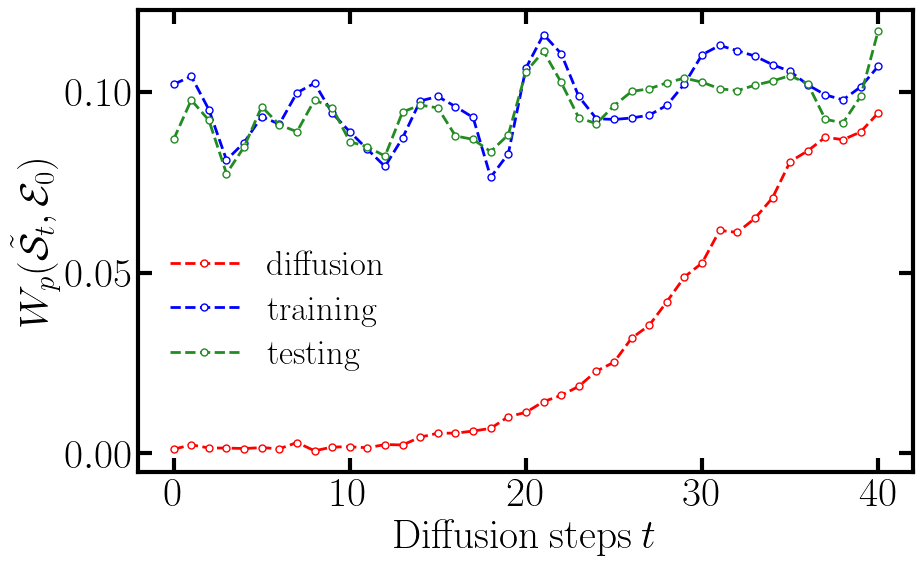

In [15]:
nd_gen = np.load('data/circle/QDDPMcircleYGenloss_n1na2T40L6_wd.npy')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(nd_gen[0], 'o--', markersize=5, mfc='white', lw=2, c='r', label=r'$\rm diffusion$')
ax.plot(nd_gen[1], 'o--', markersize=5, mfc='white', lw=2, c='b', label=r'$\rm training$')
ax.plot(nd_gen[2], 'o--', markersize=5, mfc='white', lw=2, c='forestgreen', label=r'$\rm testing$')
ax.legend(loc='lower left', bbox_to_anchor=(0., 0.15), fontsize=25, framealpha=0, labelspacing=0.4)
ax.set_xlabel(r'${\rm Diffusion\:steps}\:t$', fontsize=30)
ax.set_ylabel(r'$W_p(\tilde{\mathcal{S}}_t, \mathcal{E}_0)$', fontsize=30)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

## plot training history

C:\Users\jlsat\AppData\Local\Temp\ipykernel_10340\3669244929.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


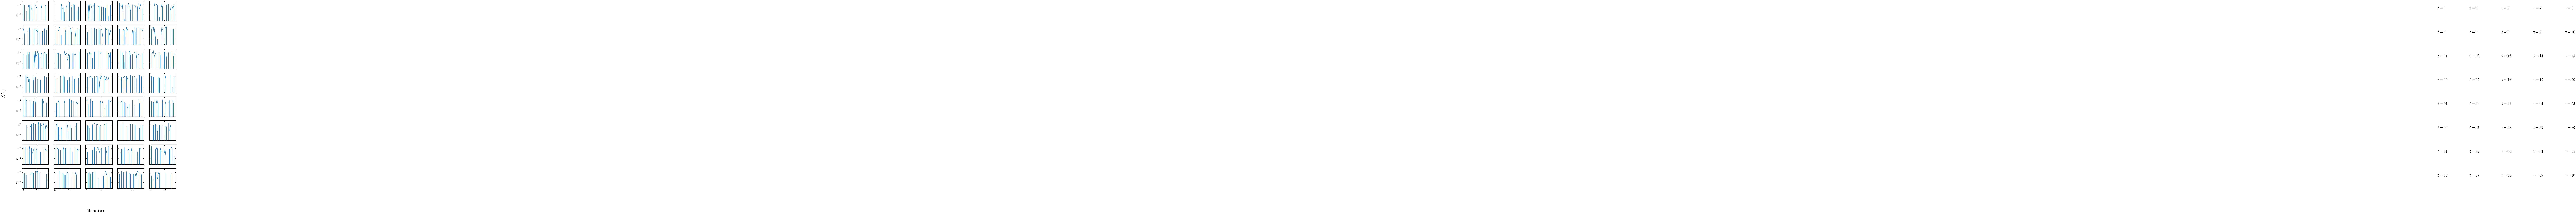

In [16]:
loss = np.load('data/circle/QDDPMcircleYloss_n1na2T40L6_wd.npy')
fig, axs = plt.subplots(8, 5, figsize=(18, 22), sharex=True, sharey=True)
for i in range(40):
    axs[i//5, i%5].plot(loss[i], lw=2)
    axs[i//5, i%5].tick_params(direction='in', length=6, width=2, top='on', right='on', labelsize=20)
    axs[i//5, i%5].text(x=3500, y=0.15, s=r'$t=%d$'%(i+1), fontsize=25)
    axs[i//5, i%5].set_yscale('log')
fig.supxlabel(r'$\rm iterations$', fontsize=30)
fig.supylabel(r'$\mathcal{L}(t)$', fontsize=30)
plt.tight_layout()